In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run ../Functions.ipynb

In [3]:
# Directory structure
base_dir = r"D:\Om Saran\ML\adobe\dataset\symmetry\Horizontal"
categories = ['yes','no'] 

In [4]:
# Data storage
data = []
labels = []

# Load data
for category in categories:
    folder_path = os.path.join(base_dir, category)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_path.endswith('.csv'):
            # Read CSV file
            points = pd.read_csv(file_path)
            data.append(points.values)  # Store points as numpy array or DataFrame
            labels.append(category)  # Store the label

In [5]:
len(data)

139

In [6]:
unique_labels = list(set(labels))
print(unique_labels)

['no', 'yes']


In [7]:
import numpy as np
num_classes = 2

def normalize_curve(points, img_size):
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    # Normalize coordinates to fit within [0, 1]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    x_normalized = (x - x_min) / (x_max - x_min)
    y_normalized = (y - y_min) / (y_max - y_min)

    # Scale coordinates to fit within the image size
    x_scaled = (x_normalized * (img_size - 1)).astype(int)
    y_scaled = (y_normalized * (img_size - 1)).astype(int)
    
    return np.vstack((x_scaled, y_scaled)).T


In [8]:
from tensorflow.keras.utils import to_categorical

# Create a mapping from label names to integers
label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
print("Label Mapping:", label_mapping)

# Convert string labels to integers
labels = np.array([label_mapping[label] for label in labels])

labels = to_categorical(labels, num_classes)  # Convert labels to one-hot encoding

Label Mapping: {'no': 0, 'yes': 1}


In [9]:
labels[0]

array([0., 1.], dtype=float32)

In [10]:
data = np.array([convert_points_to_image(p, 224) for p in data])

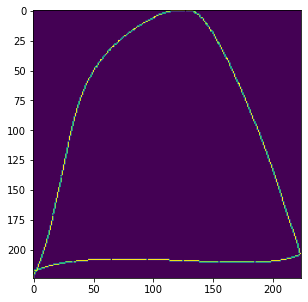

In [11]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(data[76])
# Adjust layout to add margins
fig.tight_layout(pad=0.0)  # Increase padding as needed

# Show the plot
plt.show()

In [12]:
data = np.stack([data] * 3, axis=-1)
data.shape

(139, 224, 224, 3)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.1,random_state=42)

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

def build_vgg16_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='sigmoid')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_model(num_classes)


In [15]:
model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_split=0.3)

Epoch 1/10
6/6 [==============================] - 88s 14s/step - loss: 0.7217 - accuracy: 0.5517 - val_loss: 0.6666 - val_accuracy: 0.6579
Epoch 2/10
6/6 [==============================] - 83s 14s/step - loss: 0.6277 - accuracy: 0.8161 - val_loss: 0.6346 - val_accuracy: 0.7632
Epoch 3/10
6/6 [==============================] - 84s 15s/step - loss: 0.5622 - accuracy: 0.8506 - val_loss: 0.5811 - val_accuracy: 0.7368
Epoch 4/10
6/6 [==============================] - 78s 14s/step - loss: 0.4965 - accuracy: 0.8851 - val_loss: 0.5760 - val_accuracy: 0.7632
Epoch 5/10
6/6 [==============================] - 85s 15s/step - loss: 0.4473 - accuracy: 0.8851 - val_loss: 0.5362 - val_accuracy: 0.7632
Epoch 6/10
6/6 [==============================] - 80s 14s/step - loss: 0.4146 - accuracy: 0.9195 - val_loss: 0.5418 - val_accuracy: 0.7632
Epoch 7/10
6/6 [==============================] - 82s 14s/step - loss: 0.3951 - accuracy: 0.9080 - val_loss: 0.4922 - val_accuracy: 0.7895
Epoch 8/10
6/6 [===========

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Accuracy: {accuracy:.2f}")

1/1 [==============================] - 3s 3s/step - loss: 0.6090 - accuracy: 0.7857
Accuracy: 0.79


In [17]:
model.save('../Models/model_sym_hor.h5')